In [8]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms, models
import torch.optim as optim

class MihiranNet(nn.Module):
        def __init__(self, num_classes=17):
            super(MihiranNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                #nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.01),
                nn.MaxPool2d(kernel_size=3, stride=2)
            )
            
            self.fc = nn.Sequential(
                nn.Linear(36864, 4096),
                #nn.ReLU())
                nn.LeakyReLU(negative_slope=0.01))
            self.fc1 = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(4096, num_classes),
                #nn.Softmax(dim=1) Softmax is incuded in the CrossEntropyLoss() Therefore, no need to include it here
                )
           

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = out.reshape(out.size(0), -1)#Flatten the output of the convolutional layers
            out = self.fc(out)
            out = self.fc1(out)
            return out
        

# Define transformations for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 32

#data_dir = 'data/Jute_Pest_Dataset'
data_dir = '/workspace/pattern/main/data/Jute_Pest_Dataset'

image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_classes = 17

model = MihiranNet(num_classes).to(device)

learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
num_epochs = 20

In [9]:
# Function to train the model with different learning rates
def train_with_different_lr(learning_rates):
    history = {}
    for lr in learning_rates:
        print(f'Training with learning rate: {lr}')
        model = MihiranNet(num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        training_loss_history = []
        validation_loss_history = []

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    training_loss_history.append(epoch_loss)
                else:
                    validation_loss_history.append(epoch_loss)

        history[lr] = (training_loss_history, validation_loss_history)
    return history

# Define learning rates to test
learning_rates = [0.1, 0.01, 0.001, 0.0001]

# Train the model with different learning rates
history = train_with_different_lr(learning_rates)


Training with learning rate: 0.1
Training with learning rate: 0.01
Training with learning rate: 0.001
Training with learning rate: 0.0001


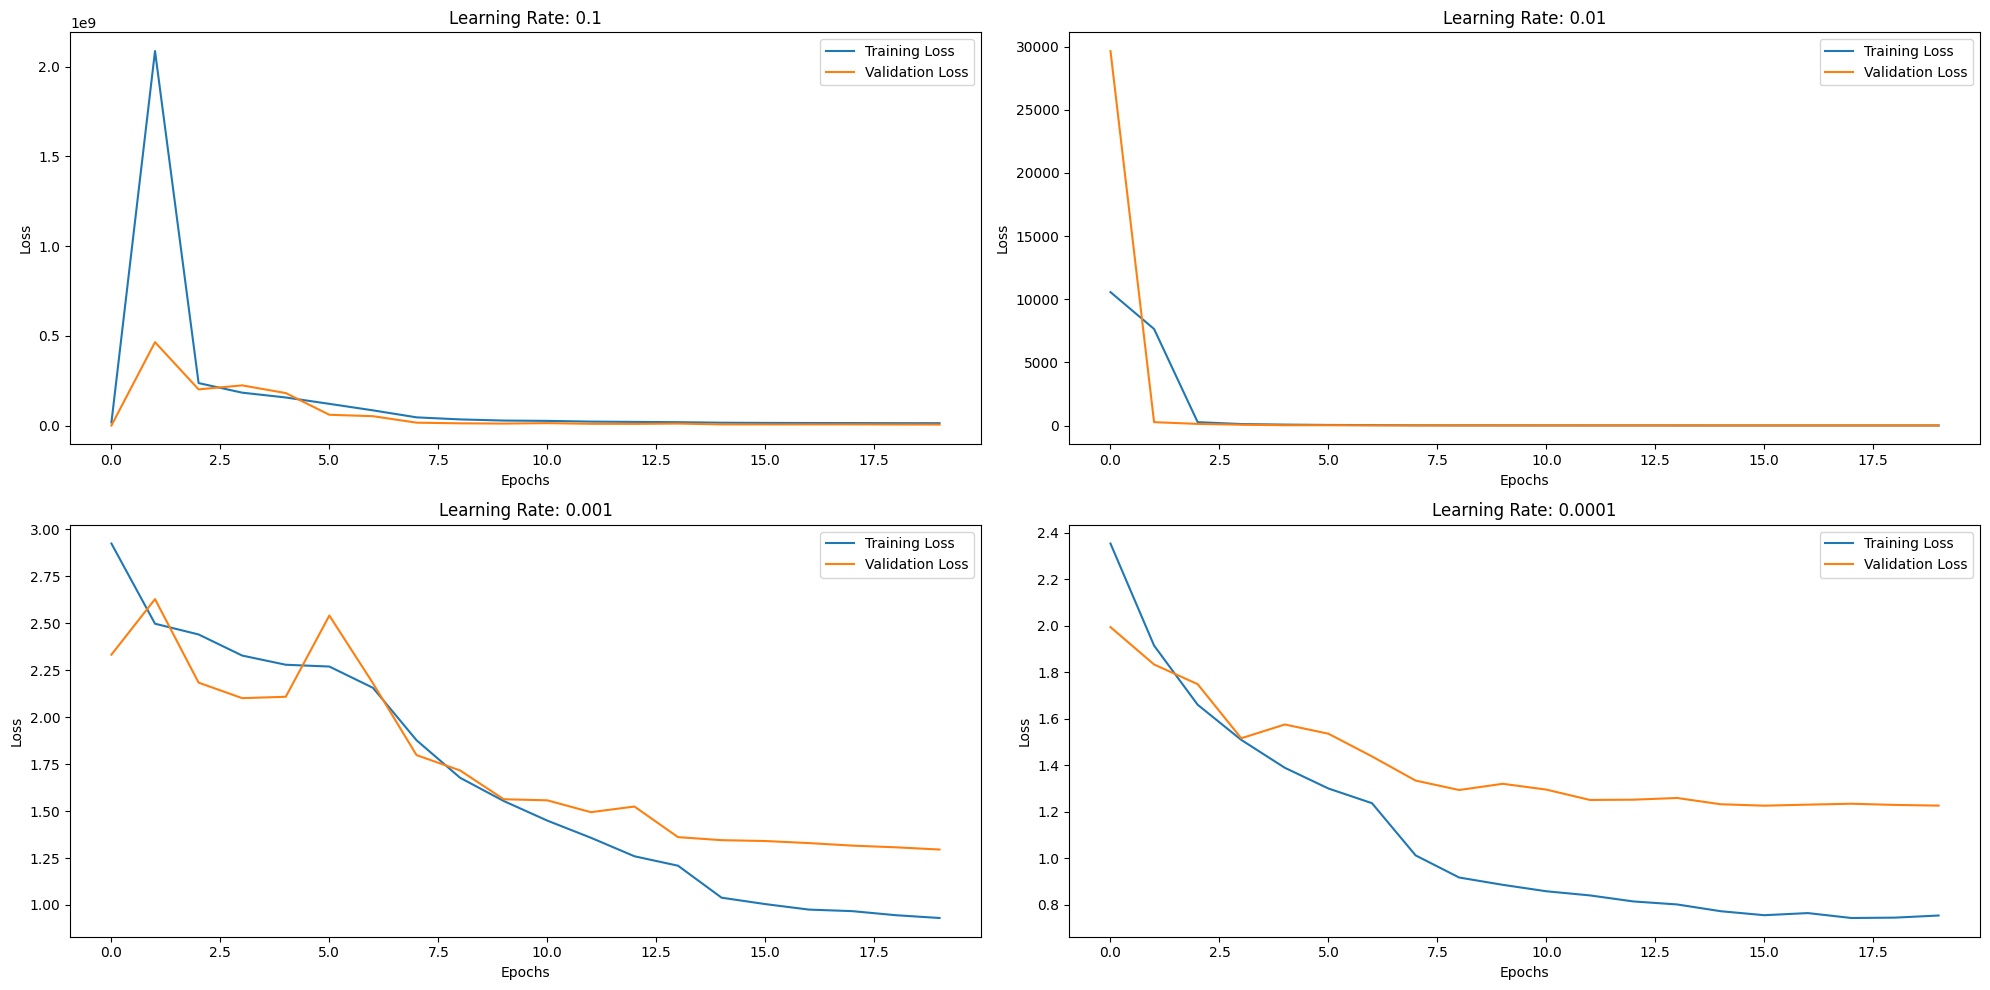

In [10]:
import matplotlib.pyplot as plt
# Plot the training and validation loss for different learning rates
plt.figure(figsize=(20, 10))
for i, lr in enumerate(learning_rates):
    training_loss, validation_loss = history[lr]
    plt.subplot(2, 2, i+1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Learning Rate: {lr}')
plt.tight_layout()
plt.show()

For traning and results refer the other notebook.  

In [1]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_training_history(training_loss, validation_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Store the loss values for each epoch
training_loss_history = []
validation_loss_history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            training_loss_history.append(epoch_loss)
        else:
            validation_loss_history.append(epoch_loss)

    print()

print('Training complete')

# Plot the training and validation loss
plot_training_history(training_loss_history, validation_loss_history)


In [2]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_training_history(training_loss, validation_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Store the loss values for each epoch
training_loss_history = []
validation_loss_history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            training_loss_history.append(epoch_loss)
        else:
            validation_loss_history.append(epoch_loss)

    print()

print('Training complete')

# Plot the training and validation loss
plot_training_history(training_loss_history, validation_loss_history)
